In [ ]:
# Dependencies installation
!pip install --quiet transformers datasets tokenizers pytorch-lightning scikit-learn pandas numpy tqdm

# Core libraries
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter

# PyTorch configuration
import torch
from torch.utils.data import Dataset, DataLoader

# Hugging Face ecosystem
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset

# Evaluation metrics
import sklearn.metrics as metrics

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment status
print(f"Device: {device}")
print("Setup completed successfully")

Device: cuda
Setup completed successfully


PyTorch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA L4

Dataset splits: ['train', 'test', 'validation']
Train: 40,000 | Validation: 5,000 | Test: 5,000

Label range: 0 - 43
Unique labels: 44
Total label instances: 395,470

Top 10 frequent labels:
  Label 10: 21,888 ( 5.53%)
  Label  0: 20,953 ( 5.30%)
  Label 23: 20,112 ( 5.09%)
  Label 22: 18,711 ( 4.73%)
  Label  6: 15,406 ( 3.90%)
  Label 20: 15,217 ( 3.85%)
  Label 12: 14,583 ( 3.69%)
  Label  8: 13,943 ( 3.53%)
  Label 28: 13,461 ( 3.40%)
  Label  2: 13,394 ( 3.39%)

Text length stats:
  Mean: 57.3 | Median: 42.0
  Min: 10 | Max: 404

Labels per text stats:
  Mean: 7.91 | Median: 8.00
  Min: 1 | Max: 22


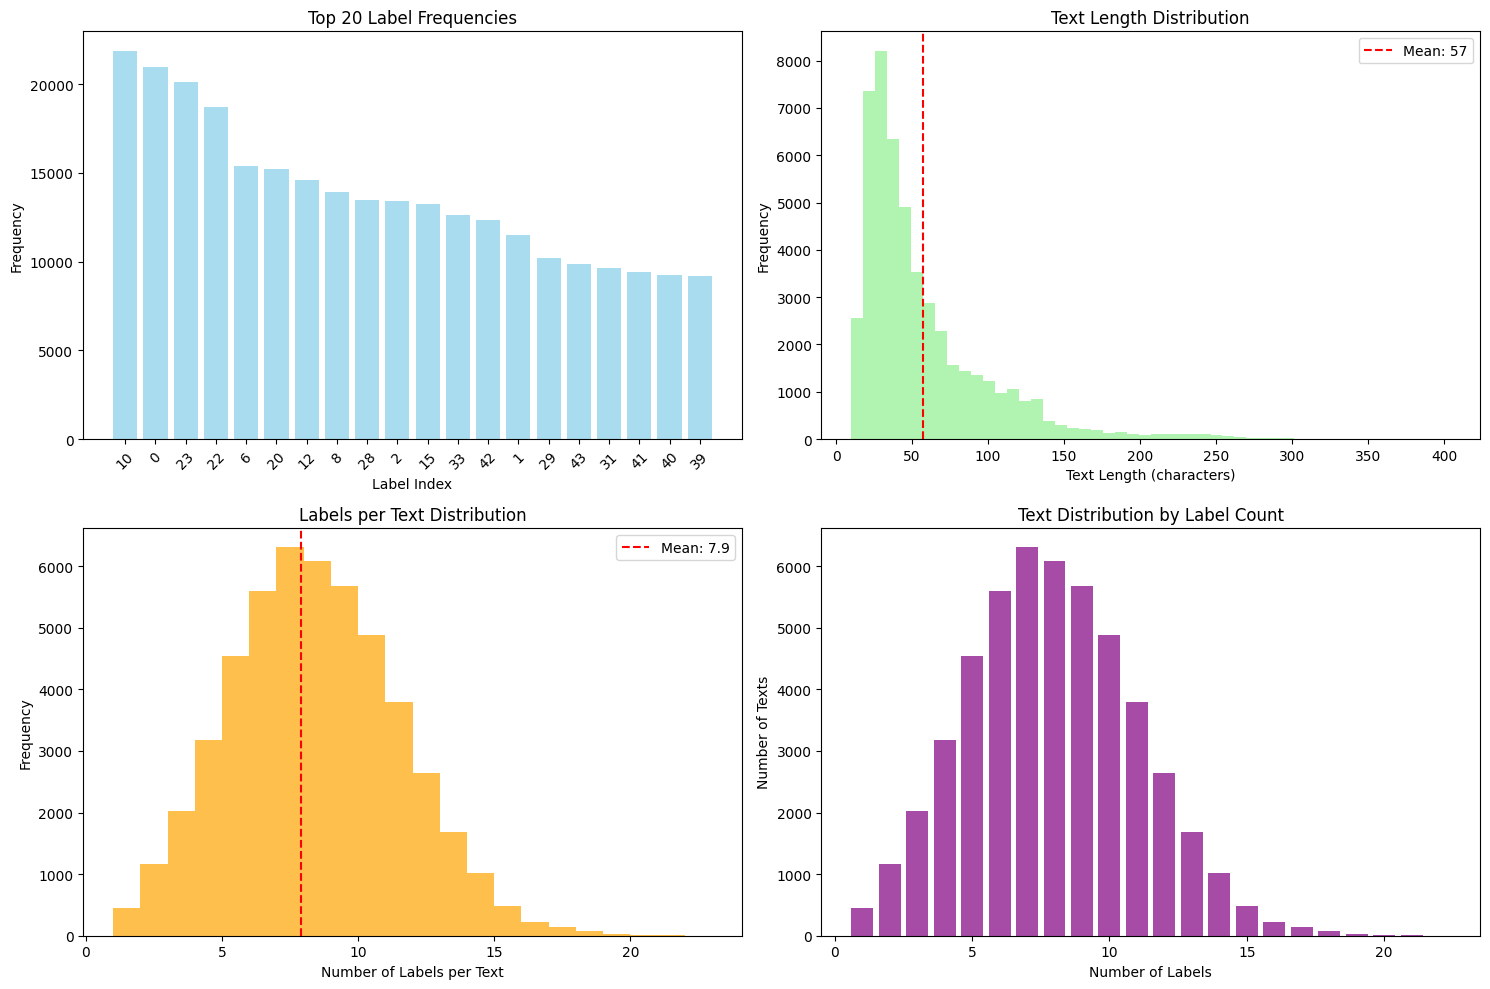


Split-wise statistics:
  TRAIN: 40,000 samples | Avg text length: 57.2 | Avg labels: 7.91
  VALIDATION: 5,000 samples | Avg text length: 58.4 | Avg labels: 7.87
  TEST: 5,000 samples | Avg text length: 57.3 | Avg labels: 7.93


In [ ]:
# KOTE dataset analysis

# Matplotlib font configuration
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams['font.family'] = 'DejaVu Sans'

# Environment check
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Load KOTE dataset
dataset = load_dataset("searle-j/kote")

# Dataset overview
print(f"\nDataset splits: {list(dataset.keys())}")
print(f"Train: {len(dataset['train']):,} | Validation: {len(dataset['validation']):,} | Test: {len(dataset['test']):,}")

# Collect all labels for analysis
all_labels = []
for split in ['train', 'validation', 'test']:
    for item in dataset[split]:
        all_labels.extend(item['labels'])

# Label statistics
unique_labels = sorted(set(all_labels))
label_counts = Counter(all_labels)

print(f"\nLabel range: {min(unique_labels)} - {max(unique_labels)}")
print(f"Unique labels: {len(unique_labels)}")
print(f"Total label instances: {len(all_labels):,}")

print(f"\nTop 10 frequent labels:")
for label, count in label_counts.most_common(10):
    percentage = (count / len(all_labels)) * 100
    print(f"  Label {label:2d}: {count:6,} ({percentage:5.2f}%)")

# Text length analysis
text_lengths = []
labels_per_text = []
for split in ['train', 'validation', 'test']:
    for item in dataset[split]:
        text_lengths.append(len(item['text']))
        labels_per_text.append(len(item['labels']))

print(f"\nText length stats:")
print(f"  Mean: {np.mean(text_lengths):.1f} | Median: {np.median(text_lengths):.1f}")
print(f"  Min: {np.min(text_lengths)} | Max: {np.max(text_lengths)}")

print(f"\nLabels per text stats:")
print(f"  Mean: {np.mean(labels_per_text):.2f} | Median: {np.median(labels_per_text):.2f}")
print(f"  Min: {np.min(labels_per_text)} | Max: {np.max(labels_per_text)}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top 20 label frequencies
top_labels = label_counts.most_common(20)
labels, counts = zip(*top_labels)
axes[0,0].bar(range(len(labels)), counts, color='skyblue', alpha=0.7)
axes[0,0].set_xlabel('Label Index')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Top 20 Label Frequencies')
axes[0,0].set_xticks(range(len(labels)))
axes[0,0].set_xticklabels(labels, rotation=45)

# Text length distribution
axes[0,1].hist(text_lengths, bins=50, alpha=0.7, color='lightgreen')
axes[0,1].set_xlabel('Text Length (characters)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Text Length Distribution')
axes[0,1].axvline(np.mean(text_lengths), color='red', linestyle='--',
                  label=f'Mean: {np.mean(text_lengths):.0f}')
axes[0,1].legend()

# Labels per text distribution
axes[1,0].hist(labels_per_text, bins=range(1, max(labels_per_text)+2),
               alpha=0.7, color='orange')
axes[1,0].set_xlabel('Number of Labels per Text')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Labels per Text Distribution')
axes[1,0].axvline(np.mean(labels_per_text), color='red', linestyle='--',
                  label=f'Mean: {np.mean(labels_per_text):.1f}')
axes[1,0].legend()

# Text count by label count
label_count_dist = Counter(labels_per_text)
counts_sorted = sorted(label_count_dist.items())
x_vals, y_vals = zip(*counts_sorted)
axes[1,1].bar(x_vals, y_vals, alpha=0.7, color='purple')
axes[1,1].set_xlabel('Number of Labels')
axes[1,1].set_ylabel('Number of Texts')
axes[1,1].set_title('Text Distribution by Label Count')

plt.tight_layout()
plt.show()

# Split-wise analysis
print(f"\nSplit-wise statistics:")
for split in ['train', 'validation', 'test']:
    split_labels = []
    split_text_lengths = []
    split_labels_per_text = []

    for item in dataset[split]:
        split_labels.extend(item['labels'])
        split_text_lengths.append(len(item['text']))
        split_labels_per_text.append(len(item['labels']))

    print(f"  {split.upper()}: {len(dataset[split]):,} samples | "
          f"Avg text length: {np.mean(split_text_lengths):.1f} | "
          f"Avg labels: {np.mean(split_labels_per_text):.2f}")

In [ ]:
# KOTE to Plutchik emotion mapping

# KOTE 44 emotion labels
KOTE_LABELS = [
    '불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경',
    '기대감', '우쭐댐/무시함', '안타까움/실망', '비장함', '의심/불신', '뿌듯함', '편안/쾌적',
    '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움',
    '짜증', '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남', '깨달음',
    '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처', '경악', '부담/안_내킴', '서러움',
    '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰'
]

# Plutchik 8 basic emotions
PLUTCHIK_EMOTIONS = {
    0: "Anger", 1: "Anticipation", 2: "Joy", 3: "Trust",
    4: "Fear", 5: "Surprise", 6: "Sadness", 7: "Disgust"
}

KOTE_TO_PLUTCHIK = {
    # ANGER (분노)
    0: 0,   # 불평/불만
    6: 0,   # 화남/분노
    22: 0,  # 짜증
    23: 0,  # 어이없음
    26: 0,  # 귀찮음

    # ANTICIPATION (기대)
    8: 1,   # 기대감
    15: 1,  # 신기함/관심

    # JOY (기쁨)
    1: 2,   # 환영/호의
    2: 2,   # 감동/감탄
    4: 2,   # 고마움
    13: 2,  # 뿌듯함
    14: 2,  # 편안/쾌적
    28: 2,  # 즐거움/신남
    29: 2,  # 깨달음
    32: 2,  # 흐뭇함
    40: 2,  # 행복
    42: 2,  # 기쁨

    # TRUST (신뢰)
    7: 3,   # 존경
    16: 3,  # 아껴주는
    43: 3,  # 안심/신뢰

    # FEAR (공포)
    12: 4,  # 의심/불신
    17: 4,  # 부끄러움
    18: 4,  # 공포/무서움
    30: 4,  # 죄책감
    35: 4,  # 부담/안내킴
    41: 4,  # 불안/걱정

    # SURPRISE (놀람)
    33: 5,  # 당황/난처
    34: 5,  # 경악
    39: 5,  # 놀람

    # SADNESS (슬픔)
    3: 6,   # 지긋지긋
    5: 6,   # 슬픔
    10: 6,  # 안타까움/실망
    11: 6,  # 비장함
    19: 6,  # 절망
    25: 6,  # 패배/자기혐오
    27: 6,  # 힘듦/지침
    36: 6,  # 서러움
    37: 6,  # 재미없음

    # DISGUST (혐오)
    9: 7,   # 우쭐댐/무시함
    20: 7,  # 한심함
    21: 7,  # 순수한 혐오감

    # NO_EMOTION
    24: -1  # 없음
}


print(f"KOTE labels: {len(KOTE_LABELS)}")
print(f"Plutchik emotions: {len(PLUTCHIK_EMOTIONS)}")

# Mapping distribution
mapping_stats = Counter(KOTE_TO_PLUTCHIK.values())
total_mapped = sum(v for k, v in mapping_stats.items() if k != -1)

print(f"\nMapping distribution:")
for plutchik_idx in range(8):
    count = mapping_stats.get(plutchik_idx, 0)
    emotion = PLUTCHIK_EMOTIONS[plutchik_idx]
    print(f"  {emotion}: {count} labels")

print(f"  Excluded (NO_EMOTION): {mapping_stats.get(-1, 0)} labels")

# Conversion function
def convert_kote_to_plutchik(kote_labels):
    """Convert KOTE labels to Plutchik labels"""
    plutchik_labels = set()
    for label in kote_labels:
        if label in KOTE_TO_PLUTCHIK and KOTE_TO_PLUTCHIK[label] != -1:
            plutchik_labels.add(KOTE_TO_PLUTCHIK[label])
    return sorted(list(plutchik_labels))

# Test conversion with sample data
print(f"\nSample conversions:")
for i in range(3):
    sample = dataset['train'][i]
    original_labels = sample['labels']
    plutchik_labels = convert_kote_to_plutchik(original_labels)

    print(f"\nSample {i+1}: {sample['text'][:50]}...")
    print(f"  KOTE: {[KOTE_LABELS[l] for l in original_labels]}")
    print(f"  Plutchik: {[PLUTCHIK_EMOTIONS[l] for l in plutchik_labels]}")

KOTE labels: 44
Plutchik emotions: 8

Mapping distribution:
  Anger: 5 labels
  Anticipation: 2 labels
  Joy: 10 labels
  Trust: 3 labels
  Fear: 6 labels
  Surprise: 3 labels
  Sadness: 9 labels
  Disgust: 3 labels
  Excluded (NO_EMOTION): 1 labels

Sample conversions:

Sample 1: 내가 톰행크스를 좋아하긴 했나보다... 초기 영화 빼고는 다 봤네....
  KOTE: ['감동/감탄', '뿌듯함', '신기함/관심', '아껴주는', '깨달음', '놀람']
  Plutchik: ['Anticipation', 'Joy', 'Trust', 'Surprise']

Sample 2: 정말 상상을 초월하는 무개념 진상들 상대하다 우울증, 공항장애 걸리는 공무원 많아요 ㅠ 생...
  KOTE: ['불평/불만', '슬픔', '존경', '안타까움/실망', '절망', '짜증', '깨달음', '부담/안_내킴', '서러움', '불쌍함/연민']
  Plutchik: ['Anger', 'Joy', 'Trust', 'Fear', 'Sadness']

Sample 3: 새로운 세상과 조우한 자의 어린아이 같은 반응, 어쩌면 회복된 것은 눈이 아닌 순수함일지도...
  KOTE: ['환영/호의', '감동/감탄', '존경']
  Plutchik: ['Joy', 'Trust']


Dataset size comparison:
  train: 40,000 → 39,913 (0.2% reduced)
  validation: 5,000 → 4,994 (0.1% reduced)
  test: 5,000 → 4,988 (0.2% reduced)

Plutchik emotion distribution:
  Anger: 28,956 (15.6%)
  Anticipation: 19,693 (10.6%)
  Joy: 27,397 (14.8%)
  Trust: 16,299 (8.8%)
  Fear: 23,122 (12.5%)
  Surprise: 21,326 (11.5%)
  Sadness: 29,554 (15.9%)
  Disgust: 19,367 (10.4%)

Labels per text stats:
  Mean: 3.72
  Min: 1 | Max: 8

Top 10 emotion combinations:
  Anticipation, Joy, Trust: 4,209 (8.4%)
  Anger, Fear, Surprise, Sadness, Disgust: 3,956 (7.9%)
  Anger, Fear, Sadness, Disgust: 3,157 (6.3%)
  Anger, Fear, Surprise, Sadness: 2,031 (4.1%)
  Anticipation, Joy: 1,867 (3.7%)
  Joy, Trust: 1,697 (3.4%)
  Anticipation, Joy, Trust, Surprise: 1,497 (3.0%)
  Anger, Sadness, Disgust: 1,351 (2.7%)
  Joy: 1,196 (2.4%)
  Anger, Fear, Sadness: 1,192 (2.4%)


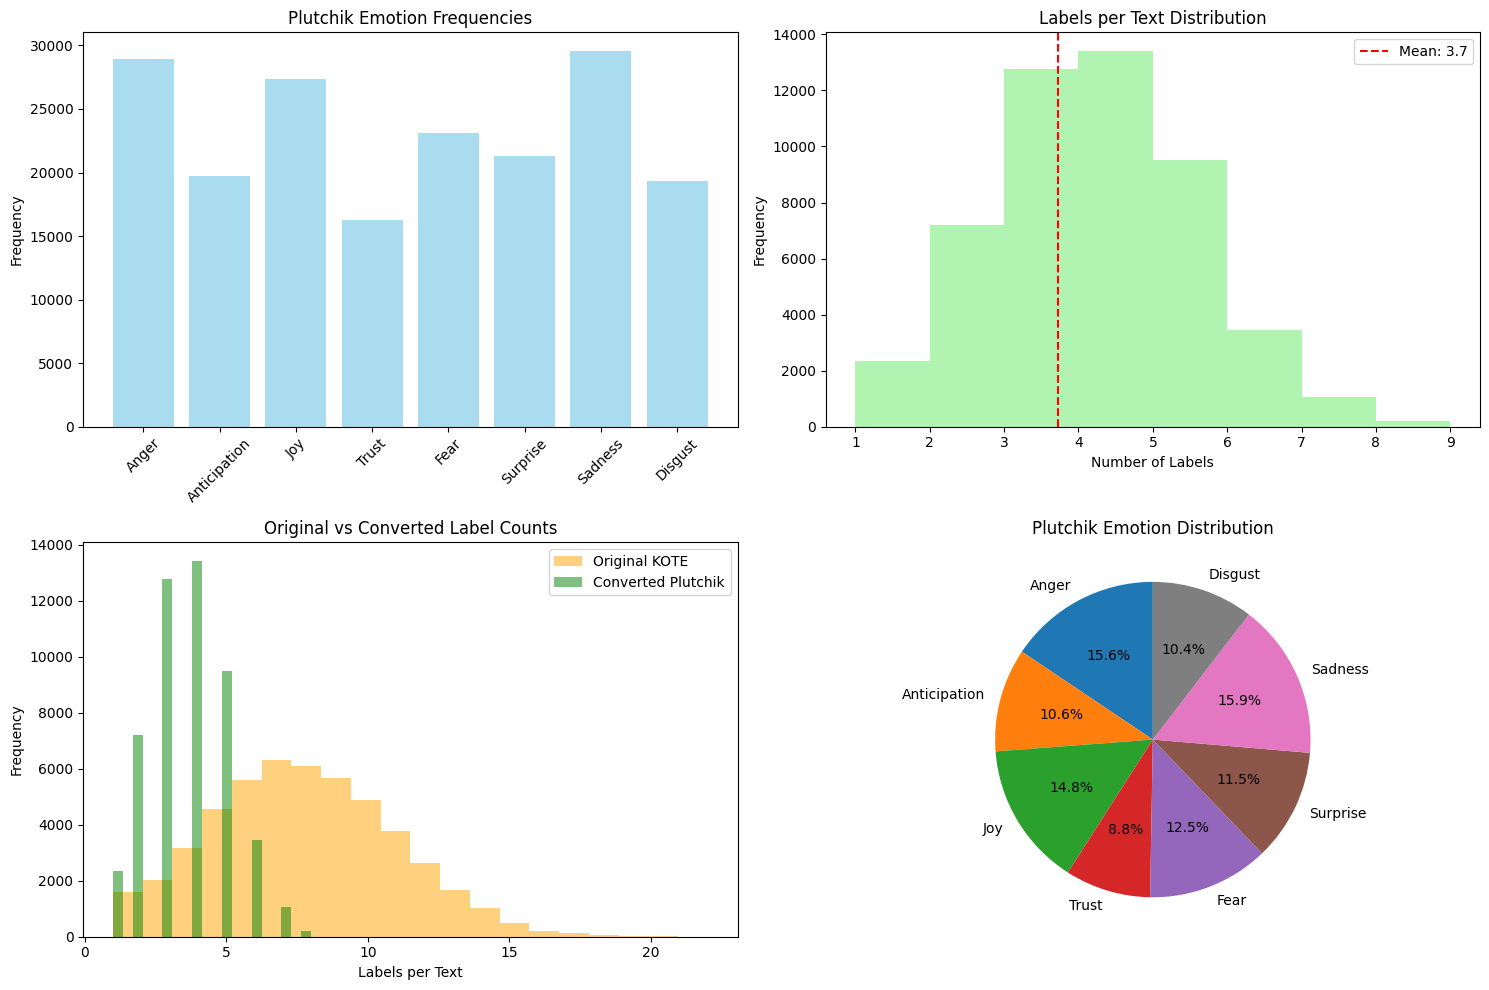


Plutchik dataset created successfully!
Total samples: 49,895
Total emotion instances: 185,714


In [ ]:
# Plutchik dataset creation and analysis

def create_plutchik_dataset(original_dataset):
    """Convert KOTE dataset to Plutchik labels"""
    plutchik_dataset = {'train': [], 'validation': [], 'test': []}

    for split in ['train', 'validation', 'test']:
        for item in original_dataset[split]:
            plutchik_labels = convert_kote_to_plutchik(item['labels'])

            # Include only samples with valid emotions (exclude NO_EMOTION)
            if plutchik_labels:
                plutchik_dataset[split].append({
                    'ID': item['ID'],
                    'text': item['text'],
                    'original_labels': item['labels'],
                    'plutchik_labels': plutchik_labels
                })

    return plutchik_dataset

# Create Plutchik dataset
plutchik_data = create_plutchik_dataset(dataset)

# Dataset size comparison
print("Dataset size comparison:")
for split in ['train', 'validation', 'test']:
    original_size = len(dataset[split])
    converted_size = len(plutchik_data[split])
    reduction_pct = ((original_size - converted_size) / original_size) * 100
    print(f"  {split}: {original_size:,} → {converted_size:,} ({reduction_pct:.1f}% reduced)")

# Plutchik label distribution
all_plutchik_labels = []
plutchik_labels_per_text = []
for split in ['train', 'validation', 'test']:
    for item in plutchik_data[split]:
        all_plutchik_labels.extend(item['plutchik_labels'])
        plutchik_labels_per_text.append(len(item['plutchik_labels']))

plutchik_counts = Counter(all_plutchik_labels)
total_labels = len(all_plutchik_labels)

print(f"\nPlutchik emotion distribution:")
for label_idx in range(8):
    count = plutchik_counts.get(label_idx, 0)
    percentage = (count / total_labels) * 100
    emotion = PLUTCHIK_EMOTIONS[label_idx]
    print(f"  {emotion}: {count:,} ({percentage:.1f}%)")

print(f"\nLabels per text stats:")
print(f"  Mean: {np.mean(plutchik_labels_per_text):.2f}")
print(f"  Min: {np.min(plutchik_labels_per_text)} | Max: {np.max(plutchik_labels_per_text)}")

# Top emotion combinations
label_combinations = []
for split in ['train', 'validation', 'test']:
    for item in plutchik_data[split]:
        labels_tuple = tuple(sorted(item['plutchik_labels']))
        label_combinations.append(labels_tuple)

combination_counts = Counter(label_combinations)
print(f"\nTop 10 emotion combinations:")
for combo, count in combination_counts.most_common(10):
    combo_names = [PLUTCHIK_EMOTIONS[idx] for idx in combo]
    percentage = (count / len(label_combinations)) * 100
    print(f"  {', '.join(combo_names)}: {count:,} ({percentage:.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plutchik emotion frequencies
labels = [PLUTCHIK_EMOTIONS[i] for i in range(8)]
counts = [plutchik_counts.get(i, 0) for i in range(8)]

axes[0, 0].bar(labels, counts, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Plutchik Emotion Frequencies')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].tick_params(axis='x', rotation=45)

# Labels per text distribution
axes[0, 1].hist(plutchik_labels_per_text, bins=range(1, max(plutchik_labels_per_text)+2),
                alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Labels per Text Distribution')
axes[0, 1].set_xlabel('Number of Labels')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.mean(plutchik_labels_per_text), color='red', linestyle='--',
                   label=f'Mean: {np.mean(plutchik_labels_per_text):.1f}')
axes[0, 1].legend()

# Original vs converted label counts
original_labels_per_text = [len(item['labels']) for split in ['train', 'validation', 'test']
                           for item in dataset[split]]
converted_labels_per_text = [len(item['plutchik_labels']) for split in ['train', 'validation', 'test']
                            for item in plutchik_data[split]]

axes[1, 0].hist(original_labels_per_text, bins=20, alpha=0.5, label='Original KOTE', color='orange')
axes[1, 0].hist(converted_labels_per_text, bins=20, alpha=0.5, label='Converted Plutchik', color='green')
axes[1, 0].set_title('Original vs Converted Label Counts')
axes[1, 0].set_xlabel('Labels per Text')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Emotion distribution pie chart
axes[1, 1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Plutchik Emotion Distribution')

plt.tight_layout()
plt.show()

print(f"\nPlutchik dataset created successfully!")
print(f"Total samples: {sum(len(plutchik_data[split]) for split in ['train', 'validation', 'test']):,}")
print(f"Total emotion instances: {total_labels:,}")

In [ ]:
# KcELECTRA model setup and data preparation

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel
from sklearn.metrics import hamming_loss, jaccard_score, f1_score
import random

# Model configuration
MODEL_NAME = "beomi/KcELECTRA-base"
BATCH_SIZE = 16
MAX_LENGTH = 64
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
WEIGHT_DECAY = 0.01

print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

# Multi-label KcELECTRA model
class PlutchikKcELECTRA(nn.Module):
    def __init__(self, model_name, num_labels=8, dropout_rate=0.3):
        super(PlutchikKcELECTRA, self).__init__()
        self.num_labels = num_labels
        self.electra = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.electra.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Dataset class
class PlutchikDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        labels = item['plutchik_labels']

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Create multi-label vector
        label_vector = torch.zeros(8, dtype=torch.float)
        for label in labels:
            if 0 <= label < 8:
                label_vector[label] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_vector,
            'text': text
        }

# Create datasets and dataloaders
train_dataset = PlutchikDataset(plutchik_data['train'], tokenizer, MAX_LENGTH)
val_dataset = PlutchikDataset(plutchik_data['validation'], tokenizer, MAX_LENGTH)
test_dataset = PlutchikDataset(plutchik_data['test'], tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaders: Train {len(train_loader)} | Val {len(val_loader)} | Test {len(test_loader)} batches")

# Initialize model
model = PlutchikKcELECTRA(MODEL_NAME, num_labels=8, dropout_rate=0.3)
model.to(device)

# Model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: {total_params:,} total | {trainable_params:,} trainable")

# Hyperparameters summary
print(f"\nHyperparameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Weight decay: {WEIGHT_DECAY}")

# Quick model test
sample_batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    sample_logits = model(
        sample_batch['input_ids'][:2].to(device),
        sample_batch['attention_mask'][:2].to(device)
    )
    print(f"Model output shape: {sample_logits.shape}")

print(f"\nModel setup completed successfully!")

Device: cuda
Model: beomi/KcELECTRA-base
Data loaders: Train 2495 | Val 313 | Test 312 batches
Parameters: 108,496,904 total | 108,496,904 trainable

Hyperparameters:
  Batch size: 16
  Max length: 64
  Learning rate: 2e-05
  Epochs: 3
  Weight decay: 0.01
Model output shape: torch.Size([2, 8])

Model setup completed successfully!


In [ ]:
# Model training and validation loop

import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, hamming_loss, jaccard_score

# Optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = BCEWithLogitsLoss()

def compute_detailed_metrics(logits, target_labels):
    """Compute detailed classification metrics"""
    # Convert to predictions
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)
    true = target_labels.cpu().numpy().astype(int)

    # Basic metrics
    ham_loss = hamming_loss(true, preds)
    jac_score = jaccard_score(true, preds, average='samples', zero_division=0)

    # Detailed classification report
    emotion_names = [PLUTCHIK_EMOTIONS[i] for i in range(8)]
    report = classification_report(
        true, preds,
        target_names=emotion_names,
        zero_division=0,
        output_dict=False
    )

    return {
        'hamming_loss': ham_loss,
        'jaccard_score': jac_score,
        'classification_report': report
    }

# Training loop
best_val_loss = float('inf')

print("Starting training...")
print("=" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    model.train()
    train_loss_sum = 0.0
    train_steps = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - Training", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_steps += 1
        loop.set_postfix(loss=train_loss_sum / train_steps)

    avg_train_loss = train_loss_sum / train_steps

    # Validation phase
    model.eval()
    val_loss_sum = 0.0
    val_steps = 0
    all_val_logits = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss_sum += loss.item()
            val_steps += 1

            all_val_logits.append(logits)
            all_val_labels.append(labels)

    avg_val_loss = val_loss_sum / val_steps

    # Combine all validation data
    all_val_logits = torch.cat(all_val_logits, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0)

    # Compute metrics
    val_metrics = compute_detailed_metrics(all_val_logits, all_val_labels)

    # Print epoch results
    print(f"\nEPOCH {epoch}/{NUM_EPOCHS} RESULTS:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Hamming Loss: {val_metrics['hamming_loss']:.4f} | Jaccard Score: {val_metrics['jaccard_score']:.4f}")
    print("\nDetailed Classification Report:")
    print(val_metrics['classification_report'])

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_plutchik_kcelectra.pt")
        print(f">>> New best model saved! (Val Loss: {avg_val_loss:.4f})")

    print("=" * 80)

print("\nTraining completed successfully!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...


Epoch 1/3 - Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/313 [00:00<?, ?it/s]


EPOCH 1/3 RESULTS:
Train Loss: 0.4677 | Val Loss: 0.4295
Hamming Loss: 0.2049 | Jaccard Score: 0.6687

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.88      0.87      0.87      2949
Anticipation       0.72      0.75      0.74      1946
         Joy       0.88      0.82      0.85      2691
       Trust       0.75      0.70      0.72      1603
        Fear       0.67      0.86      0.76      2355
    Surprise       0.69      0.63      0.66      2167
     Sadness       0.80      0.89      0.85      2999
     Disgust       0.72      0.72      0.72      1917

   micro avg       0.77      0.79      0.78     18627
   macro avg       0.77      0.78      0.77     18627
weighted avg       0.78      0.79      0.78     18627
 samples avg       0.78      0.83      0.78     18627

>>> New best model saved! (Val Loss: 0.4295)


Epoch 2/3 - Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Epoch 2/3 - Validation:   0%|          | 0/313 [00:00<?, ?it/s]


EPOCH 2/3 RESULTS:
Train Loss: 0.3989 | Val Loss: 0.4255
Hamming Loss: 0.2021 | Jaccard Score: 0.6700

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.90      0.84      0.87      2949
Anticipation       0.72      0.78      0.75      1946
         Joy       0.84      0.88      0.86      2691
       Trust       0.70      0.81      0.75      1603
        Fear       0.73      0.73      0.73      2355
    Surprise       0.73      0.57      0.64      2167
     Sadness       0.81      0.88      0.84      2999
     Disgust       0.74      0.68      0.71      1917

   micro avg       0.78      0.78      0.78     18627
   macro avg       0.77      0.77      0.77     18627
weighted avg       0.78      0.78      0.78     18627
 samples avg       0.80      0.82      0.78     18627

>>> New best model saved! (Val Loss: 0.4255)


Epoch 3/3 - Training:   0%|          | 0/2495 [00:00<?, ?it/s]

Epoch 3/3 - Validation:   0%|          | 0/313 [00:00<?, ?it/s]


EPOCH 3/3 RESULTS:
Train Loss: 0.3554 | Val Loss: 0.4336
Hamming Loss: 0.1993 | Jaccard Score: 0.6778

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.88      0.88      0.88      2949
Anticipation       0.71      0.78      0.75      1946
         Joy       0.87      0.85      0.86      2691
       Trust       0.76      0.72      0.74      1603
        Fear       0.71      0.81      0.75      2355
    Surprise       0.68      0.67      0.68      2167
     Sadness       0.82      0.88      0.85      2999
     Disgust       0.73      0.71      0.72      1917

   micro avg       0.78      0.80      0.79     18627
   macro avg       0.77      0.79      0.78     18627
weighted avg       0.78      0.80      0.79     18627
 samples avg       0.80      0.83      0.78     18627


Training completed successfully!
Best validation loss: 0.4255


In [41]:
# Test set evaluation

import numpy as np
from sklearn.metrics import classification_report, hamming_loss, jaccard_score

# Load best model
model.load_state_dict(torch.load("best_plutchik_kcelectra.pt", map_location=device))
model.to(device)
model.eval()

# Collect predictions
all_true = []
all_pred = []

print("Evaluating on test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        # Get predictions
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_true.append(labels)
        all_pred.append(preds)

# Combine results
y_true = np.vstack(all_true)
y_pred = np.vstack(all_pred)

# Emotion names for report
emotion_names = [f"{emotion}" for emotion in PLUTCHIK_EMOTIONS.values()]

# Generate classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=emotion_names,
    zero_division=0
)

# Additional metrics
ham_loss = hamming_loss(y_true, y_pred)
jac_score = jaccard_score(y_true, y_pred, average='samples', zero_division=0)

# Results
print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test samples: {len(y_true):,}")
print(f"Hamming Loss: {ham_loss:.4f}")
print(f"Jaccard Score: {jac_score:.4f}")
print("\nDetailed Classification Report:")
print(report)
print("="*60)

<ipython-input-41-c9a193b8c9fd>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_plutchik_kcelectra.pt", map_location=device))


Evaluating on test set...


Testing:   0%|          | 0/312 [00:00<?, ?it/s]


TEST SET EVALUATION RESULTS
Test samples: 4,988
Hamming Loss: 0.2021
Jaccard Score: 0.6697

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.90      0.85      0.88      2915
Anticipation       0.71      0.78      0.74      1934
         Joy       0.84      0.88      0.86      2729
       Trust       0.68      0.80      0.74      1584
        Fear       0.75      0.73      0.74      2376
    Surprise       0.72      0.58      0.64      2166
     Sadness       0.81      0.87      0.84      2961
     Disgust       0.76      0.68      0.71      1954

   micro avg       0.78      0.78      0.78     18619
   macro avg       0.77      0.77      0.77     18619
weighted avg       0.79      0.78      0.78     18619
 samples avg       0.80      0.82      0.78     18619



In [42]:
# Emotion prediction for user input

def predict_emotions(text, threshold=0.5):
    """Predict emotions for given text"""
    # Tokenize input
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    # Apply threshold
    preds = (probs >= threshold).astype(int)

    return probs, preds

emotion_names = list(PLUTCHIK_EMOTIONS.values())

print("Enter text to predict emotions (type '0' to exit)")

while True:
    # Get user input
    text = input("\nEnter text: ").strip()

    # Check for exit commands
    if text == '0':
        break

    # Skip empty input
    if not text:
        print("Please enter some text.")
        continue

    # Predict emotions
    probs, preds = predict_emotions(text)

    # Show predicted emotions
    active_emotions = [emotion_names[j] for j, p in enumerate(preds) if p == 1]

    print(f"\nText: \"{text}\"")
    if active_emotions:
        print(f"Predicted emotions: {', '.join(active_emotions)}")
    else:
        print("Predicted emotions: None (below threshold)")

    # Show probabilities
    print("Emotion probabilities:")
    for j, emotion in enumerate(emotion_names):
        status = "✓" if preds[j] == 1 else " "
        print(f"  {status} {emotion}: {probs[j]:.3f}")

Enter text to predict emotions (type '0' to exit)

Enter text: 국힘이 무능하고 모지리들이지만 아무리 그래도 범죄자들을 찍어줄수는 없지

Text: "국힘이 무능하고 모지리들이지만 아무리 그래도 범죄자들을 찍어줄수는 없지"
Predicted emotions: Anger, Fear, Sadness, Disgust
Emotion probabilities:
  ✓ Anger: 0.987
    Anticipation: 0.019
    Joy: 0.024
    Trust: 0.015
  ✓ Fear: 0.957
    Surprise: 0.351
  ✓ Sadness: 0.890
  ✓ Disgust: 0.879

Enter text: 악셀을 힘껏 밟으면 급가속이 일어남

Text: "악셀을 힘껏 밟으면 급가속이 일어남"
Predicted emotions: Anger, Joy, Fear, Surprise, Sadness
Emotion probabilities:
  ✓ Anger: 0.727
    Anticipation: 0.324
  ✓ Joy: 0.582
    Trust: 0.099
  ✓ Fear: 0.554
  ✓ Surprise: 0.883
  ✓ Sadness: 0.581
    Disgust: 0.246

Enter text: 동성애는 정신병이다. 사형시켜라

Text: "동성애는 정신병이다. 사형시켜라"
Predicted emotions: Anger, Fear, Surprise, Sadness, Disgust
Emotion probabilities:
  ✓ Anger: 0.991
    Anticipation: 0.009
    Joy: 0.023
    Trust: 0.030
  ✓ Fear: 0.718
  ✓ Surprise: 0.581
  ✓ Sadness: 0.645
  ✓ Disgust: 0.772

Enter text: 감형해 주는 판사놈도 똥꼬 까서 이놈저놈 구경 시켜야 함. 그래야 피해

KeyboardInterrupt: Interrupted by user